In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "cs231n/lora_w_diffusion-main/"
assert FOLDERNAME is not None, "[!] Enter the foldername."
PROJECT_PATH = f"/content/drive/My Drive/{FOLDERNAME}"
sys.path.append(PROJECT_PATH)

# Change working directory
os.chdir(PROJECT_PATH)

# Confirm
print("✅ Current working directory:", os.getcwd())
print("📁 Contents:", os.listdir('.'))

Mounted at /content/drive
✅ Current working directory: /content/drive/My Drive/cs231n/lora_w_diffusion-main
📁 Contents: ['dataset.py', 'README.md', 'lora.py', 'requirements.txt', 'clip.py', '.gitignore', 'augment.py', 'data_curation', 'data_chinese', 'data_english', 'utils', 'model_weights', '__pycache__', 'wandb', 'generated_images', '.ipynb_checkpoints', 'lora_weights.pth', 'patch_unet.py', 'baseline_sd_sample.ipynb', 'fid.py', 'lora_sd_colab.ipynb']


# 💡 LoRA Training on Stable Diffusion
This notebook trains custom LoRA adapters on Stable Diffusion using your own image-caption pairs.


In [ ]:
!pip install -q diffusers transformers accelerate torchvision safetensors kornia wandb torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.

## Data Preparation

In [ ]:
# Hyper params
lora_rank = 2
lora_alpha = 1
epochs = 1
lr = 1e-4
dropout = 0.1
dataset = "data_chinese"
in_training_prompt = "米芾 行书"
num_img_to_generate = 3
agumentation = True
conv_lora = True
device = "cuda"

run_name = f"dataset_{dataset}_rank_{lora_rank}_alpha_{lora_alpha}_epochs_{epochs}_conv_{int(conv_lora)}_lr_{lr:.0e}_dropout_{dropout}_augment_{int(agumentation)}"
print(run_name)

dataset_data_chinese_rank_2_alpha_1_epochs_1_conv_1_lr_1e-04_dropout_0.1_augment_1


In [ ]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
from dataset import ImageTextDataset

dataset = ImageTextDataset(dataset)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# sanity check for datasets
print(f"Number of image-caption pairs: {len(dataset)}")

Number of image-caption pairs: 348


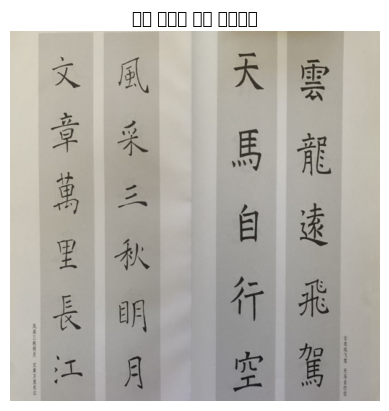

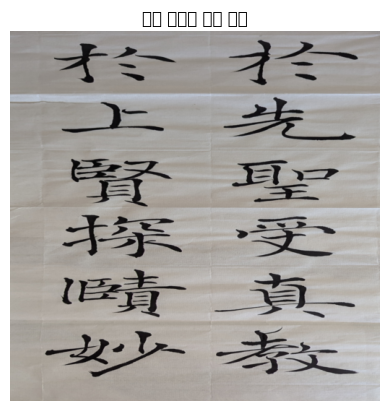

In [ ]:
# preview a couple of images.
from matplotlib import pyplot as plt
import warnings
import re

# This regex will match messages containing "Glyph" and "missing from font"
warnings.filterwarnings("ignore", category=UserWarning, message=r"Glyph .* missing from font\(s\) DejaVu Sans\.")

for i in range(min(2, len(dataset))):  # Show up to 3 examples
    image, caption = dataset[i]
    plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Undo normalization
    plt.axis("off")
    plt.title(caption)
    plt.show()


## Training Logic for Lora Finetuning

In [ ]:
import wandb
import os
os.environ["WANDB_API_KEY"] = "d3cb18c48782c92319e4f2a53d26a05e702caa3e"
wandb.login()

wandb.init(
    project="stable-diffusion-calligraphy",
    name=run_name,  # give each experiment a unique name
    config={
        "lora_rank": lora_rank,
        "lora_alpha": lora_alpha,
        "lr": lr,
        "epochs": epochs,
        "augmentations": False,
        "conv_lora": conv_lora,
    }
)

wandb: Currently logged in as: jessicaqmwn (baibaipangpang-bbpp-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from lora import LoRALinear, LoRAConv2d
from patch_unet import patch_unet_with_lora, conv_filter

from diffusers import StableDiffusionPipeline
import torch.nn as nn


pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float32).to(device)

pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.unet.requires_grad_(False)

# ADD LORA
patch_unet_with_lora(pipe.unet, r=lora_rank, alpha=lora_alpha, dropout=dropout, conv_filter=None)

pipe.unet.to(device)  # Move after patching

# unfreeze lora weights
for module in pipe.unet.modules():
    if isinstance(module, (LoRALinear, LoRAConv2d)):
        for p in module.parameters():
            p.requires_grad = True

optimizer = torch.optim.Adam([p for p in pipe.unet.parameters() if p.requires_grad], lr=lr)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Loads the CLIP model and processor
from clip import calculate_clip_score
from transformers import CLIPProcessor, CLIPModel

clip_model_name ="openai/clip-vit-large-patch14" # Consistent with CompVis/stable-diffusion-v1-4
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
def generate_and_log_image(pipe, clip_model, clip_processor, device, prompt, epoch):
    """
    Generate an image from a prompt using the pipeline, calculate CLIP score,
    and log the result to Weights & Biases.

    Args:
        pipe: The diffusion pipeline.
        clip_model: The CLIP model for scoring.
        clip_processor: The processor for CLIP input.
        device: torch.device to use.
        prompt (str): Text prompt to generate image from.
        epoch (int): Current training epoch, for logging.
    """
    with torch.no_grad():
        image = pipe(prompt, num_inference_steps=30).images[0]

    # Calculate CLIP score
    clip_score = calculate_clip_score(image, prompt, clip_model, clip_processor, device)

    # Log image, score, and prompt to wandb
    wandb.log({
        "epoch": epoch,
        "generated_image": wandb.Image(image, caption=f"{prompt} | score: {clip_score:.3f}"),
        "clip_score": clip_score,
    })

    return image, clip_score  # optionally return for other use

In [ ]:
import torch
from augment import augment
from patch_unet import save_lora_weights, load_lora_weights
import torch.nn as nn

# Save model run with different hyper parameter separately
model_path = f"model_weights/{run_name}.pth"

# training
for epoch in range(epochs):
    for i, (images, captions) in enumerate(loader):
        # Keep images in float32
        images = images.to(device)

        images = augment(images)

        text_input = pipe.tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt").to(device)
        text_embeds = pipe.text_encoder(**text_input).last_hidden_state.to(device)  # stays float32

        with torch.no_grad():
            vae_output = pipe.vae.encode(images)
        latents = vae_output.latent_dist.sample().to(device) * 0.18215  # float32

        noise = torch.randn_like(latents).to(device)  # float32 noise
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()

        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

        noise_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states=text_embeds).sample  # float32

        loss = nn.MSELoss()(noise_pred, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"Epoch {epoch} Step {i} Loss: {loss.item():.4f}")
        wandb.log({
            "epoch": epoch,
            "step": i,
            "loss": loss.item(),
            "lr": optimizer.param_groups[0]["lr"],
        })

    # Log one of the input images
    sample_image = (images[0].cpu().numpy() * 0.5 + 0.5).transpose(1, 2, 0)
    wandb.log({
        "input_image": wandb.Image(sample_image, caption=captions[0])
    })

    # Generate and log output image + clip score
    generate_and_log_image(pipe, clip_model, clip_processor, device, in_training_prompt, epoch)


save_lora_weights(pipe.unet, path=model_path)

Epoch 0 Step 0 Loss: 0.1218
Epoch 0 Step 1 Loss: 0.3179
Epoch 0 Step 2 Loss: 0.0072
Epoch 0 Step 3 Loss: 0.2441
Epoch 0 Step 4 Loss: 0.0178
Epoch 0 Step 5 Loss: 0.0098
Epoch 0 Step 6 Loss: 0.0589
Epoch 0 Step 7 Loss: 0.0830
Epoch 0 Step 8 Loss: 0.0552
Epoch 0 Step 9 Loss: 0.0819
Epoch 0 Step 10 Loss: 0.2243
Epoch 0 Step 11 Loss: 0.1243
Epoch 0 Step 12 Loss: 0.1043
Epoch 0 Step 13 Loss: 0.1362
Epoch 0 Step 14 Loss: 0.1476
Epoch 0 Step 15 Loss: 0.0018
Epoch 0 Step 16 Loss: 0.2543
Epoch 0 Step 17 Loss: 0.4429
Epoch 0 Step 18 Loss: 0.2008
Epoch 0 Step 19 Loss: 0.2769
Epoch 0 Step 20 Loss: 0.0016
Epoch 0 Step 21 Loss: 0.0148
Epoch 0 Step 22 Loss: 0.0329
Epoch 0 Step 23 Loss: 0.1668
Epoch 0 Step 24 Loss: 0.0201
Epoch 0 Step 25 Loss: 0.4769
Epoch 0 Step 26 Loss: 0.3007
Epoch 0 Step 27 Loss: 0.0205
Epoch 0 Step 28 Loss: 0.2957
Epoch 0 Step 29 Loss: 0.0096
Epoch 0 Step 30 Loss: 0.1129
Epoch 0 Step 31 Loss: 0.0156
Epoch 0 Step 32 Loss: 0.0701
Epoch 0 Step 33 Loss: 0.0312
Epoch 0 Step 34 Loss: 0.

  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


## Generate images with Trained LoRA

In [ ]:
import os
import torch
import wandb

# Load LoRA weights and patch UNet
# model_path = "lora_weights.pth"
model_path = f"model_weights/{run_name}.pth"

state_dict = torch.load(model_path, map_location=device)
patch_unet_with_lora(pipe.unet, r=lora_rank, alpha=lora_alpha)
pipe.unet.load_state_dict(state_dict, strict=False)
pipe.unet.eval()

# Setup output
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

# Define prompts
chinese_prompts = [
    ("米芾 行书", "米芾_行书_generated"),
    ("褚遂良 楷书", "褚遂良_楷书_generated"),
    ("楷书", "楷书_generated")
]

# Define prompts
english_prompts = [
    ("mi fu chinese caligraphy xingshu", "米芾_caligraphy_generated"),
    ("chu suiliang chinese caligraphy kaishu", "褚遂良_caligraphy_generated"),
    ("chinese caligraphy kaishu", "kaishu_caligraphy_generated")
]

baseline_prompts = [
    # not in training set
    ("邓石如 隶书", "邓石如_隶书_generated"),
    ("deng shiru chinese caligraphy lishu", "邓石如_lishu_caligraphy_generated"),

    # some english non caligraphy prompt
    ("a beautiful sunset in California", "sunset_generated"),
    ("a cute cat", "cute_cat_generated"),
]

all_propmpts = chinese_prompts + english_prompts + baseline_prompts

def generate_log_display_images(prompt, filename_prefix):
    for i in range(num_img_to_generate):
        image = pipe(prompt, num_inference_steps=30).images[0]
        clip_score = calculate_clip_score(
            image, prompt, clip_model, clip_processor, device
        )

        wandb.log({
            "prompt": prompt,
            "clip_score": clip_score,
            "output image": wandb.Image(image, caption=f"{prompt} | score: {clip_score:.3f}")
        })
        print (f"{prompt} | clip_score {clip_score}")
        image_path = os.path.join(output_dir, f"{filename_prefix}_{i}.png")
        image.save(image_path)
        image.show()
        display(image)  # for inline notebook display

# Run generation for all prompts
for prompt_text, filename_prefix in all_propmpts:
    generate_log_display_images(prompt_text, filename_prefix)


Output hidden; open in https://colab.research.google.com to view.

##[Optional] Visualize Layers

In [ ]:
import torch.nn as nn

print("Available Conv2d layers in the UNet:")
for name, module in pipe.unet.named_modules():
    if isinstance(module, nn.Conv2d):
        print(f"- {name} (Output shape usually depends on input size)")

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from patch_unet import remove_all_hooks, register_hooks, get_activation

activations = {}
# --- Choose Layers and Register Hooks ---
layers_to_visualize = [
    'down_blocks.0.resnets.0.conv1',
    'up_blocks.0.resnets.0.conv1',
    'mid_block.resnets.0.conv2'
]

# Clear previous hooks/activations if running multiple times
remove_all_hooks()
activations.clear()

register_hooks(pipe.unet, layers_to_visualize)

In [ ]:
prompt = "米芾 行书"
generator = torch.Generator(device=device).manual_seed(42) # Use a seed for reproducibility

print("Running inference...")
image = pipe(prompt, num_inference_steps=30, generator=generator).images[0]
print("Inference complete.")

# It's crucial to remove hooks *after* inference
remove_all_hooks()

In [ ]:
from patch_unet import plot_activations

for layer_name in layers_to_visualize:
    # Choose batch_index=0 or batch_index=1 to see the difference
    plot_activations(layer_name, num_cols=16, scale=1.5, batch_index=0)
    #plot_activations(layer_name, num_cols=16, scale=1.5, batch_index=1)

##Merge Lora weights back to the base stable diffusion model

# Evaluate model performance

## Generate image folders with Trained LoRA

In [ ]:
device = "cuda"

# Define prompts
author_chinese = ["米芾", "褚遂良", "邓石如", "书法家"]
author_english = ["mi fu", "chu sui liang", "deng shi ru", "calligrapher"]
script_chinese = ["字体", "书法", "楷书", "行书", "草书", "隶书"]
script_english = ["script", "calligraphy", "regular script", "semi-cursive script", "cursive script", "clerical script"]
unrelated = ["cat", "tree", "dog", "sunrise", "sunset"]
confusion = ["email", "text mesage", "paper"]

# Setup output path
base_output_dir = f"generated_images/{run_name}"
os.makedirs(base_output_dir, exist_ok=True)

In [ ]:
# Load LoRA weights and patch UNet
import torch

model_path = f"model_weights/{run_name}.pth"

state_dict = torch.load(model_path, map_location=device)
patch_unet_with_lora(pipe.unet, r=lora_rank, alpha=lora_alpha)
pipe.unet.load_state_dict(state_dict, strict=False)
pipe.unet.eval()

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRALinear(
                  (dropout): Dropout(p=0.1, inplace=False)
                  (base_linear): Linear(in_features=320, out_features=320, bias=False)
                  (lora_down

In [ ]:
import wandb
def generate_image(prompt, output_dir, filename_prefix):
    """
    Generates images based on a text prompt using a Stable Diffusion pipeline,
    calculates a CLIP score for each generated image, saves the image, and
    optionally logs the image and its score to Weights & Biases (wandb).
    """
    for i in range(num_image_to_generate_per_prompt):
        image = pipe(prompt, num_inference_steps=30).images[0]
        clip_score = calculate_clip_score(
            image, prompt, clip_model, clip_processor, device
        )
        print (f"{prompt} | clip_score {clip_score}")
        image_path = os.path.join(output_dir, f"{filename_prefix}_{i}.png")
        image.save(image_path)
        if log_generated_image:
          wandb.log({
            "prompt": prompt,
            "clip_score": clip_score,
            "output image": wandb.Image(image, caption=f"{prompt} | score: {clip_score:.3f}")
          })
          image.show()
          display(image)  # for inline notebook display

def generate_caligraphy_images(author_list, script_list, sub_dir):
    '''
    Generates calligraphy images for a list of authors and scripts, saving them
    into a structured directory
    '''
    output_dir = os.path.join(base_output_dir, sub_dir)
    for author in author_list:
      # Create a subdirectory for each author to compare style
      author_dir = os.path.join(output_dir, author.replace(" ", "_"))
      os.makedirs(author_dir, exist_ok=True)
      for script in script_list:
          prompt = f"{author} {script}"
          filename_prefix = prompt.replace(" ", "_")
          generate_image(prompt, author_dir, filename_prefix)

In [ ]:
# Generates images from the model for evaluation
log_generated_image = False
num_image_to_generate_per_prompt = 1

# Generate calligraphy with chinese prompt
generate_caligraphy_images(author_chinese, script_chinese, "chinese")

# Generate calligraphy with english prompt
generate_caligraphy_images(author_english, script_english, "english")

# Generate images with unrelated prompt
output_dir = os.path.join(base_output_dir, "unrelated")
os.makedirs(output_dir, exist_ok=True)
for prompt in unrelated:
    filename_prefix = prompt
    generate_image(prompt, output_dir, filename_prefix)

# Generate images with confusion prompt
output_dir = os.path.join(base_output_dir, "confusion")
os.makedirs(output_dir, exist_ok=True)
for prompt in confusion:
    filename_prefix = prompt
    generate_image(prompt, output_dir, filename_prefix)

  0%|          | 0/30 [00:00<?, ?it/s]

mi fu script | clip_score 0.2105318009853363


  0%|          | 0/30 [00:00<?, ?it/s]

mi fu calligraphy | clip_score 0.2883053719997406


  0%|          | 0/30 [00:00<?, ?it/s]

mi fu regular script | clip_score 0.26346203684806824


  0%|          | 0/30 [00:00<?, ?it/s]

mi fu semi-cursive script | clip_score 0.2855539321899414


  0%|          | 0/30 [00:00<?, ?it/s]

mi fu cursive script | clip_score 0.2552548944950104


  0%|          | 0/30 [00:00<?, ?it/s]

mi fu clerical script | clip_score 0.27164435386657715


  0%|          | 0/30 [00:00<?, ?it/s]

chu sui liang script | clip_score 0.2790926694869995


  0%|          | 0/30 [00:00<?, ?it/s]

chu sui liang calligraphy | clip_score 0.3099808692932129


  0%|          | 0/30 [00:00<?, ?it/s]

chu sui liang regular script | clip_score 0.2685110569000244


  0%|          | 0/30 [00:00<?, ?it/s]

chu sui liang semi-cursive script | clip_score 0.3091500699520111


  0%|          | 0/30 [00:00<?, ?it/s]

chu sui liang cursive script | clip_score 0.28688502311706543


  0%|          | 0/30 [00:00<?, ?it/s]

chu sui liang clerical script | clip_score 0.2603820562362671


  0%|          | 0/30 [00:00<?, ?it/s]

deng shi ru script | clip_score 0.27248531579971313


  0%|          | 0/30 [00:00<?, ?it/s]

deng shi ru calligraphy | clip_score 0.31612884998321533


  0%|          | 0/30 [00:00<?, ?it/s]

deng shi ru regular script | clip_score 0.2882281243801117


  0%|          | 0/30 [00:00<?, ?it/s]

deng shi ru semi-cursive script | clip_score 0.296317994594574


  0%|          | 0/30 [00:00<?, ?it/s]

deng shi ru cursive script | clip_score 0.284404456615448


  0%|          | 0/30 [00:00<?, ?it/s]

deng shi ru clerical script | clip_score 0.2866629958152771


  0%|          | 0/30 [00:00<?, ?it/s]

calligrapher script | clip_score 0.2822720408439636


  0%|          | 0/30 [00:00<?, ?it/s]

calligrapher calligraphy | clip_score 0.27428779006004333


  0%|          | 0/30 [00:00<?, ?it/s]

calligrapher regular script | clip_score 0.24720677733421326


  0%|          | 0/30 [00:00<?, ?it/s]

calligrapher semi-cursive script | clip_score 0.2548055052757263


  0%|          | 0/30 [00:00<?, ?it/s]

calligrapher cursive script | clip_score 0.2674139440059662


  0%|          | 0/30 [00:00<?, ?it/s]

calligrapher clerical script | clip_score 0.2703213393688202


  0%|          | 0/30 [00:00<?, ?it/s]

cat | clip_score 0.2319633513689041


  0%|          | 0/30 [00:00<?, ?it/s]

tree | clip_score 0.22732816636562347


  0%|          | 0/30 [00:00<?, ?it/s]

dog | clip_score 0.19835856556892395


  0%|          | 0/30 [00:00<?, ?it/s]

sunrise | clip_score 0.20163996517658234


  0%|          | 0/30 [00:00<?, ?it/s]

sunset | clip_score 0.20393991470336914


  0%|          | 0/30 [00:00<?, ?it/s]

email | clip_score 0.16774797439575195


  0%|          | 0/30 [00:00<?, ?it/s]

text mesage | clip_score 0.20205192267894745


  0%|          | 0/30 [00:00<?, ?it/s]

paper | clip_score 0.19381999969482422


In [ ]:
wandb.finish()

## Compute Frechet Inception Distance (FID)

In [ ]:
# Parameter for generate images and evaluation
from torchvision import transforms
from fid import load_images_from_folder, calculate_fid_score, add_fake_data_and_calculate_fid_score, calculate_fid_score_between_folders

# TODO: Tune transform to capture calligraphy related features in FID
# Preprocess images:
target_size = (299, 299)
# Resize and transform to gray scale.
transform = transforms.Compose([
  transforms.Resize(target_size),
  transforms.Grayscale(num_output_channels=3), # Convert to grayscale with 1 output channel
])

### Baseline: FID between two real images datasets

In [ ]:
import os
from torchmetrics.image.fid import FrechetInceptionDistance
# Baseline: fid similarity between real datasets

base_input_dir = "data_curation"
show_example = False

mifu = "米芾"
chu = "褚遂良/褚遂良_千字文"
cat = "cat"
sunrise = "sunrise"

mifu_real_image_path = os.path.join(base_input_dir, "chinese", mifu)
chu_real_image_path = os.path.join(base_input_dir, "chinese", chu)
cat_real_image_path = os.path.join(base_input_dir, "unrelated", cat)
sunrise_real_image_path = os.path.join(base_input_dir, "unrelated", sunrise)

_, mifu_real_images = load_images_from_folder(mifu_real_image_path, transform, device, show_example)
_, chu_real_images = load_images_from_folder(chu_real_image_path, transform, device, show_example)
_, cat_real_images = load_images_from_folder(cat_real_image_path, transform, device, show_example)
_, sunrise_real_images = load_images_from_folder(sunrise_real_image_path, transform, device, show_example)

# FID real mifu and real mifu
score = calculate_fid_score(mifu_real_images, mifu_real_images, device)
print (f"fid score between {mifu} {mifu} : {score}")

# FID real mifu and real chu sui liang
score = calculate_fid_score(chu_real_images, mifu_real_images, device)
print (f"fid score between {chu} {mifu}: {score}")

# FID real mifu and real cat
score = calculate_fid_score(cat_real_images, mifu_real_images, device)
print (f"fid score between {cat} {mifu} : {score}")

# FID real mifu and real sun rise
score = calculate_fid_score(sunrise_real_images, mifu_real_images, device)
print (f"fid score between {sunrise} {mifu} : {score}")

fid score between 米芾 米芾 : -0.00026336402515880764
fid score between 褚遂良/褚遂良_千字文 米芾: 351.1910400390625
fid score between cat 米芾 : 435.13818359375
fid score between sunrise 米芾 : 569.560791015625


### Model evaluation: FID between generated image and real images dataset

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

show_example = False

all_generated_images = []
for author in author_chinese:
  generated_path = os.path.join(base_output_dir, "chinese", author.replace(" ", "_"))
  _, generated_images = load_images_from_folder(generated_path, transform, device, show_example)
  all_generated_images.append((generated_images, author))

for author in author_english:
  generated_path = os.path.join(base_output_dir, "english", author.replace(" ", "_"))
  _, generated_images = load_images_from_folder(generated_path, transform, device, show_example)
  all_generated_images.append((generated_images, author))

unrelated_path = os.path.join(base_output_dir, "unrelated")
_, generated_images = load_images_from_folder(unrelated_path, transform, device, show_example)
all_generated_images.append((generated_images, "unrelated"))

confusion_path = os.path.join(base_output_dir, "confusion")
_, generated_images = load_images_from_folder(confusion_path, transform, device, show_example)
all_generated_images.append((generated_images, "confusion"))

# FID with real mi fu
for imgs in all_generated_images:
  images, image_name = imgs
  score = calculate_fid_score(images, mifu_real_images, device)
  print (f"fid score between [{image_name}] and [real mi fu]: {score}")

# FID with real chu sui liang
chu_fid = FrechetInceptionDistance(normalize=True).to(device)
chu_fid.update(chu_real_images, real=True)
for imgs in all_generated_images:
  images, image_name = imgs
  score = calculate_fid_score(images, chu_real_images, device)
  print (f"fid score between [{image_name}] and [real chu sui liang]: {score}")

# FID with real cat
for imgs in all_generated_images:
  images, image_name = imgs
  score = calculate_fid_score(images, cat_real_images, device)
  print (f"fid score between [{image_name}] and [real cat]: {score}")

# FID with real sun rise
for imgs in all_generated_images:
  images, image_name = imgs
  score = calculate_fid_score(images, sunrise_real_images, device)
  print (f"fid score between [{image_name}] and [real sunrise]: {score}")

fid score between [米芾] and [real mi fu]: 260.88262939453125
fid score between [褚遂良] and [real mi fu]: 306.8054504394531
fid score between [邓石如] and [real mi fu]: 257.5799865722656
fid score between [书法家] and [real mi fu]: 291.9316101074219
fid score between [mi fu] and [real mi fu]: 203.28794860839844
fid score between [chu sui liang] and [real mi fu]: 255.7235870361328
fid score between [deng shi ru] and [real mi fu]: 170.06784057617188
fid score between [calligrapher] and [real mi fu]: 397.2248229980469
fid score between [unrelated] and [real mi fu]: 527.666259765625
fid score between [confusion] and [real mi fu]: 548.922119140625
fid score between [米芾] and [real chu sui liang]: 489.4227294921875
fid score between [褚遂良] and [real chu sui liang]: 485.59466552734375
fid score between [邓石如] and [real chu sui liang]: 423.7048034667969
fid score between [书法家] and [real chu sui liang]: 418.6366882324219
fid score between [mi fu] and [real chu sui liang]: 393.090087890625
fid score between 